## Example 0: Getting started with bayesian optimization using PARyOpt
1- dimensional

What you will learn:
* setting up logger
* initializing the optimization
* updating iterations
* getting optimization related data such as function evaluations, existing data points, ..
* visualization

Step 1: Import relevant packages

In [2]:
import logging
import time

import numpy as np
import examples.examples_all_functions as exf
from PARyOpt import BayesOpt
from PARyOpt.evaluators import FunctionEvaluator

We shall first set up the logging for the optimization routine:

This is done through the logging module, and the following code
can be used as a template for any generic logging purpose:
If the logger is not set up, then it will output to the screen by default

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)  # either NOTSET, INFO, DEBUG, WARNING, ERROR, CRITICAL -- different levels of log
log_file_name = 'example0_{}.log'.format(time.strftime("%Y.%m.%d-%H%M%S"))
fh = logging.FileHandler(log_file_name, mode='a')

# log file format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

# first line of the log
logger.info('Example run for Bayesian optimization')


Let us start setting up the optimization routine: Firstly, we will need to define
* the number of parameters to optimize,
* bounds for each parameter
* max number of iterations
* batch size

In [13]:
# n_dim = 2
# l_bound = np.asarray([-12., -12.])
# u_bound = np.asarray([12., 12.])


n_dim = 1
l_bound = np.asarray([-12.])
u_bound = np.asarray([12.])

n_init = 2
max_iter = 10
batch_size = 1


Let us now define the cost function for the problem. In reality, this will be some form of black-box cost function

The signature of cost function is :
Input: numpy array
Output: float

In [14]:
def parabolic_cost_function(x: np.array) -> float:
    """
    y = (x-2.5) ^ 2 + 5
    Dimension independant
    :param x: location
    :return:
    """
    y = np.sum((x+0.5) ** 2  * (x-6.5)**2+ 5)
    return float(y)

We will now convert this cost function to be taken into PARyOpt. For this , we simply wrap it with the function:
`FunctionEvaluator()`

In [15]:
evaluator = FunctionEvaluator(parabolic_cost_function)

Let us now start the optimization procedure. For this, we will also need a `kappa` strategy,i.e. an 
exploration-exploitation strategy. For this example, let us do a pure exploration, i.e, we want 
to specify high value of kappa.

In [16]:
def my_kappa(iteration: int) -> float:
    """
    return a constant kappa value of 1000.
    :param iteration: iteration
    :return:
    """
    return 1000.0

b_opt = BayesOpt(cost_function=evaluator,
                 l_bound=l_bound, u_bound=u_bound, n_dim=n_dim,
                 n_init=n_init,
                 kern_function='sqr_exp',
                 acq_func='LCB',
                 kappa_strategy=my_kappa,
                 if_restart=False)

logger.info('BO initialized')

This instantiation of `BayesOpt` will automatically start the initial runs (function evaluations). 
Let us now visualize the surrogate that is constructed, along with the target cost function

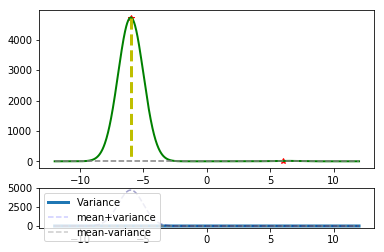

At [0.], surrogate mean:[7.22986176e-05], variance:[1.], true value:11.25


In [17]:
# visualize the surrogate generated by the optimizer, with no hyper-parameter optimization
exf.visualize_fit(b_opt)

# an example of how to evaluate the surrogate at any point and see how far it is from the actual cost function
pt_to_evaluate = np.asarray([0.0])
mean, variance = b_opt.evaluate_surrogate_at(pt_to_evaluate)
true_cost_function = exf.parabolic_cost_function(pt_to_evaluate)

print('At {}, surrogate mean:{}, variance:{}, true value:{}'.format(pt_to_evaluate, mean, variance,
                                                                    true_cost_function))

We can now set up the optimization routine to search for the optimum. This is done as follows:

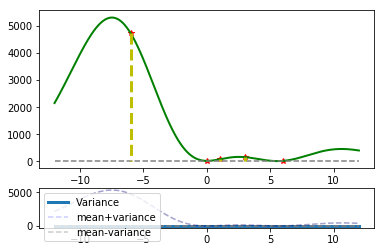

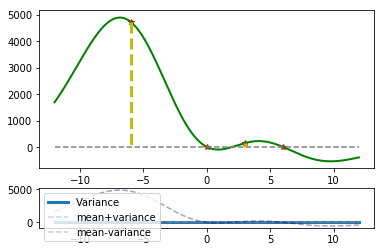

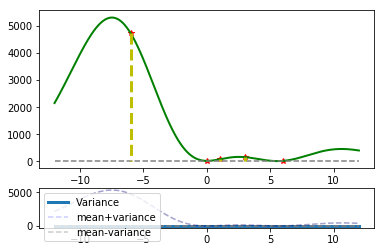

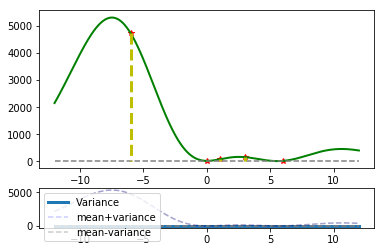

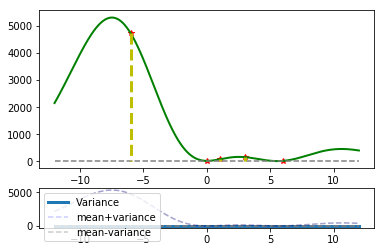

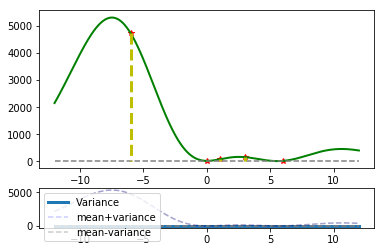

In [18]:
for curr_iter in range(max_iter):
    # update_iter finds acquisition function optima and updates the prior to get the posterior
    # (optimize acquisition function to pick the next set of points,
    # evaluate the cost function at those points, and update the surrogate with the new values)
    b_opt.update_iter()
    # estimate and set best kernel parameters
    b_opt.estimate_best_kernel_parameters(theta_bounds=[[0.1, 10]])
    # visualize it every other iteration
    if curr_iter % 2:
        exf.visualize_fit(b_opt)

Get the population and respective function values from the optimizer. This will be needed to restart whenever required.

In [19]:
total_population, function_values = b_opt.get_total_population()
# get current best evaluated value
best_location, best_value = b_opt.get_current_best()

result_txt = 'Optimization done for {} iterations, best evaluation is at {} with cost: {}'.format(b_opt.get_current_iteration(), best_location, best_value)

logger.info(result_txt)
print(result_txt)

Optimization done for 10 iterations, best evaluation is at [6.] with cost: 15.5625
Optimization done for 10 iterations, best evaluation is at [6.] with cost: 15.5625


Data saving strategies

In [20]:
csv_file = '../temp/example_0_data.csv'
b_opt.export_csv(csv_file)
logger.info('Data exported to {}'.format(csv_file))